# <center> <font style="color:rgb(100,109,254)"> Image Segmentation with Mask R-CNN  </font> </center>

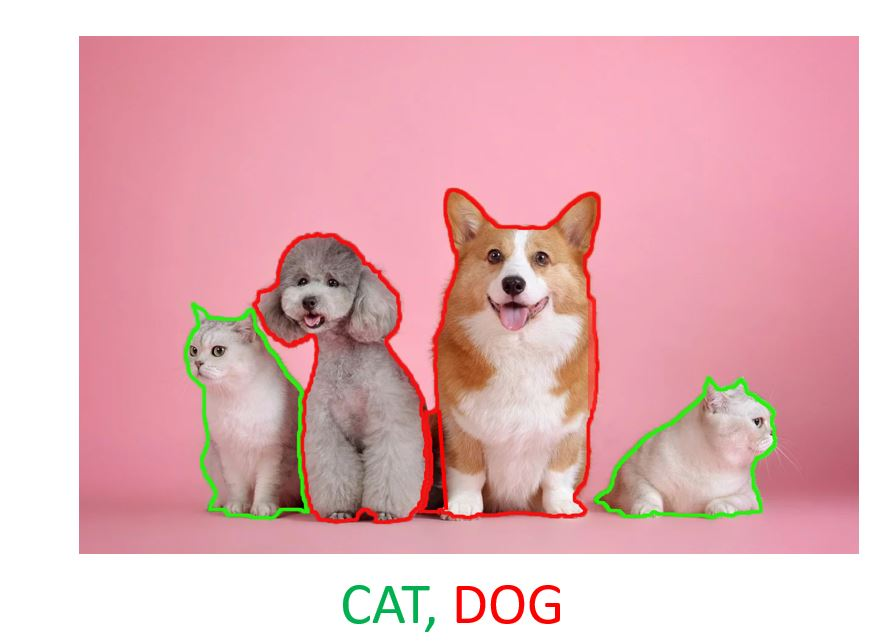

## <font style="color:rgb(134,19,348)"> Image Segmentation  </font> 

In the previous notebooks we have used multiple techniques for segmentation, from basic thresholding to color masking, to algorithms like watershed & grabcut etc. Now we will use a deep neural net called `Mask RCNN` for segmentation. This will not only give us a pixel-wise mask for each object in the image but will also produce bounding boxes of each object.

## <font style="color:rgb(134,19,348)"> Types of Image Segmentation</font> 

Image Segmentation can be generally divided into 2 categories.

**Two types of Image segmentation:**

- **`Semantic segmentation:`**	 
- **`Instance segmentation:`**	 

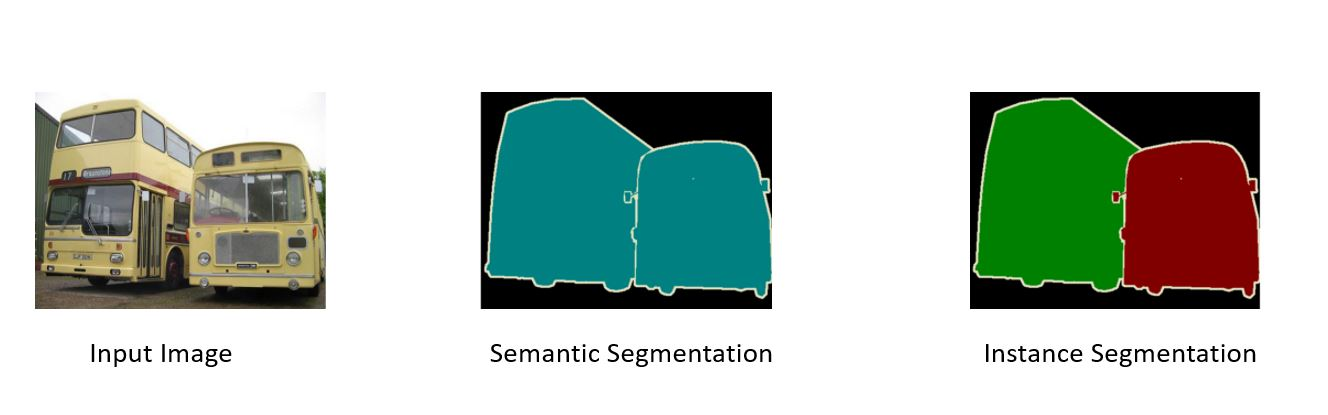


## <font style="color:rgb(134,19,348)">   Semantic Segmentation</font> 

In Semantic Segmentation  we are just interesting in segmenting the objects but we can't differentiate between pixels of the same class. This means if there are multiple overlapping objects of the same class then we cant segment them individually. 

## <font style="color:rgb(134,19,348)"> Instance Segmentation</font> 

In Instance Segmentation not only we segment each object from background but we also differentiate between objects of the same class.

**`Mask RCNN` that we'll be using is an Instance Segmentation Network. This algorithm was introduced by He et al. in their 2017 paper, [Mask R-CNN.](https://arxiv.org/abs/1703.06870)**  This algorithm comes from the family of RCNNs and builds on them. 

In [103]:
# Import Required Libraries
import numpy as np
import random
import time
import cv2
import os
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk

## <font style="color:rgb(134,19,348)"> Loading the Class Labels</font>

Lets load the COCO Class labels, we're working COCO 90 class version. We'll be drawing each class with a unique color.

In [104]:
# Here we are loading our class label and processing them in a required format
CLASSES = open("Media/M4/Model/object_detection_classes_coco.txt").read().strip().split('\n')

# Set random seed for same randomization.
np.random.seed(50)

# Randomly select the colors that shall segment our image.
COLORS = np.random.randint(100, 255, size=(10, 3))

# Print length of loaded classes
print("Length of Classes: {} \n ".format(len(CLASSES)))

# Print the classes labels
print(CLASSES)

Length of Classes: 90 
 
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## <font style="color:rgb(134,19,348)"> Read Image</font>


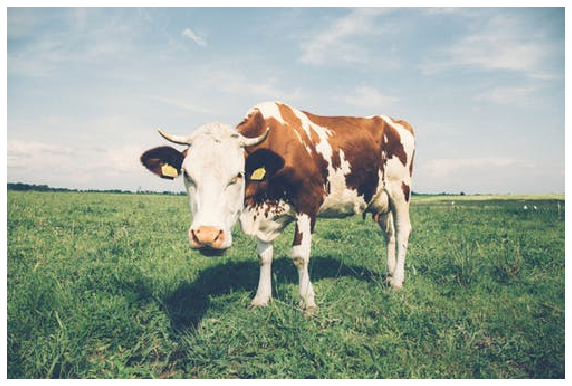

In [105]:
# Load the input image
image = cv2.imread('Media/M4/cow.jpeg')

# Display image
plt.figure(figsize=(10,10))        
plt.imshow(image[:,:,::-1])
plt.axis('off');

## <font style="color:rgb(134,19,348)"> Initializing the DNN Module </font>

Here we will load the model weights and configuration for `Mask-RCNN`. Since our Model is trained in tensorflow we'll be using  **cv2.dnn.readNetFromTensorflow()** . The only difference here is that the order of weights and config files will be reversed. 


In [106]:
# Select the weights and configuration file path
weights = 'Media/M4/Model/frozen_inference_graph.pb'
config = 'Media/M4/Model/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt'

# Load the Mask R-CNN model.
net = cv2.dnn.readNetFromTensorflow(weights, config)

## <font style="color:rgb(134,19,348)">  Pre-processing the image 
</font>


In [107]:
# Get width and height of image.
(h, w) = image.shape[:2]

# Here we are processing the image format before entering into netwrok
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)

## <font style="color:rgb(134,19,348)"> Input blob image to the network </font>

In [108]:
# Passing the blob as input through the network 
net.setInput(blob)

## <font style="color:rgb(134,19,348)">  Forwarding Image in our Network
</font>

Here we are forwarding the input image and and in the output we get 2 lists, bounding boxes and segmentation masks of image.

In [111]:
%%time
# Here we're defining the output layers we want the output from.
output_layers = ["detection_out_final", "detection_masks"]

(Rect_boxes, Segmented_masks) = net.forward(output_layers)

Wall time: 2.4 s


In [112]:
# We have 100 detections and for each detection we have a 15x15 segmentation map for all 90 classes.
Segmented_masks.shape

(100, 90, 15, 15)

In [113]:
Rect_boxes.shape

(1, 1, 100, 7)

In [114]:
Rect_boxes[0][0][0]

array([ 0.        , 20.        ,  0.99959654,  0.2444683 ,  0.24972403,
        0.7431804 ,  0.8333912 ], dtype=float32)

**These 7 values are:**

1. **`This is the index of image for a single image its 0`**

2. **`This is the index of the target CLASS`**

3. **`This is the Probability of that CLASS`**

*Remaining 4 values are x1,y1,x2,y2. These are used to draw the bounding box of that CLASS object*

4.  **`x1`**

5.  **`y1`**

6.  **`x2`**

7.  **`y2`**

## <font style="color:rgb(134,19,348)">  Detection with Mask-RCNN
</font>

Lets first perform detection with the values returned from Mask-RCNN. As you can see the procedure is pretty similar to detection with SSD.

cow: 99.96%


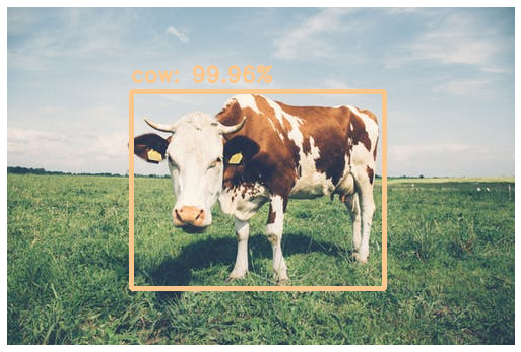

In [115]:
# Create new copy of our image
img_copy = image.copy()

# Define number of columns and rows
cols = 2
rows = 2

# Define Figure Size
plt.figure(figsize=(20,20))

# Set a confidence threshold.
Threshold = 0.5

# Iterating the detection we got
for idx,i in enumerate(range(0, Rect_boxes.shape[2]),1):
    
    # Fetching the confidence of class class label
    confidence = Rect_boxes[0, 0, i, 2]
    
    # Fetching the class index
    index = int(Rect_boxes[0, 0, i, 1])
    
    if confidence > Threshold:  
        
        # Fetching coordinates of detections
        Rect_box = Rect_boxes[0, 0, i, 3:7] * np.array([w, h, w, h])
        (X1, X2, Y1, Y2) = Rect_box.astype("int")
        
        # Display the class index and confidence score
        label = "{}: {:.2f}%".format(CLASSES[index], confidence * 100)
        
        print(label)
        
        # Here we are randomizing the color 
        color = random.randint(100,255),random.randint(200,255),random.randint(180,255)
        
        # Draw Rectangle around its suroundings 
        cv2.rectangle(img_copy, (X1, X2), (Y1, Y2),color, 4)
        
         # Put the Label of the detected object 
        cv2.putText(img_copy, label, (X1, X2-10),cv2.FONT_ITALIC, 0.7, color, 2)
        
        # Display detections
        plt.subplot(rows,cols,idx);
        plt.imshow(img_copy[:,:,::-1])
        plt.axis('off')                

## <font style="color:rgb(134,19,348)"> Segmentation with Mask-RCNN </font>

Now below we will also segment our target Object. We will also blend the segmented area with a color for a more pleasing look.

(31423, 3)


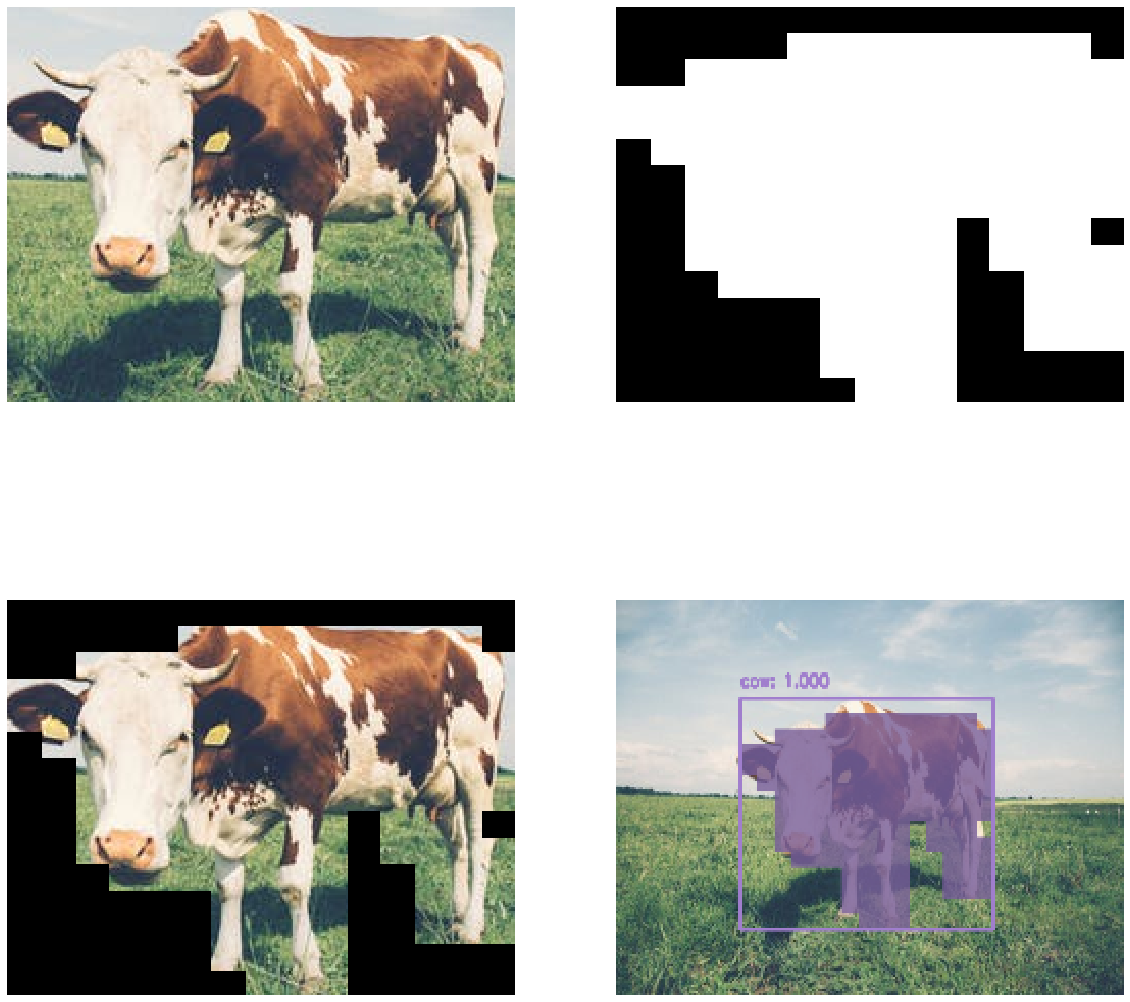

In [123]:
img_copy = image.copy()

# Set the threshold for the mask
mask_thresh = 0.08

# Define Figure Size
plt.figure(figsize=(20,20))

# Iterating the detection we got
for i in range(0, Rect_boxes.shape[2]):
    
    # Fetching the confidence of class class label
    confidence = Rect_boxes[0, 0, i, 2]
    
    # Fetching the class index
    index = int(Rect_boxes[0, 0, i, 1])
    
    if confidence > Threshold:  
        
        # Fetching coordinates of detections
        Rect_box = Rect_boxes[0, 0, i, 3:7] * np.array([w, h, w, h])
        (X1, X2, Y1, Y2) = Rect_box.astype("int")
        
        # Creating copy of image
        img_copy = image.copy()
        
        # Here we fetching the height and width of bounding box
        bwidth = Y1 - X1
        bheight = Y2 - X2
        
        # Here we take out the pixel-wise segmentation for the object, it has a 15x15 size.
        P_mask = Segmented_masks[i, index]
        
        # Resize the mask according to size of the actual Object.
        P_mask = cv2.resize(P_mask, (bwidth, bheight), interpolation=cv2.INTER_NEAREST) 
        
        # Here we store mask if pixel-wise mask greater than our given mask threshold
        mask = P_mask > mask_thresh
        
        # Here we grab the region of interest from our image
        ROI = img_copy[X2:Y2, X1:Y1]
        
        # Create copy of of ROI
        ROI_copy = ROI.copy()
        
        # Here we are multiplying binary mask with 255 and converting data type to unsigned integer
        visual_Mask = (mask * 255).astype("uint8")
    
        # Select the region of the object , filter using the mask.
        instance = cv2.bitwise_and(ROI, ROI, mask = visual_Mask)

        # Here we are extracting the mask ROI 
        ROI_mask = ROI[mask]

        # Pick up the random color from the range of 0 - 255 for every segmented object
        c = random.choice(COLORS)
        
        # Here we are creating blended ROI by blending our Roi with our randomly choosed color
        blended_roi = ((0.5 * c) + (0.4 * ROI_mask)).astype("uint8")
        print(blended_roi.shape)

        # Set the blended roi in the copy of original image
        img_copy[X2:Y2, X1:Y1][mask] = blended_roi
        
        # Select color and draw the bounding box on image
        color = [int(c1) for c1 in c]
        cv2.rectangle(img_copy, (X1, X2), (Y1, Y2), color, 2)

        # Write the predicted label with its confidence 
        label = "{}: {:.3f}".format(CLASSES[index], confidence)
        cv2.putText(img_copy, label, (X1, X2 - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Resizing the image for displaying it.
        img_copy = cv2.resize(img_copy,(ROI_copy.shape[1],ROI_copy.shape[0]))
        
        # Display detections
        plt.subplot(rows,cols,1);plt.imshow(ROI_copy[:,:,::-1]);plt.axis('off') 
        plt.subplot(rows,cols,2);plt.imshow(visual_Mask, cmap='gray');plt.axis('off') 
        plt.subplot(rows,cols,3);plt.imshow(instance[:,:,::-1]);plt.axis('off') 
        plt.subplot(rows,cols,4);plt.imshow(img_copy[:,:,::-1]);plt.axis('off') 

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [124]:
def init_segmentation(usegpu = 'None',weights_name = 'frozen_inference_graph.pb',
                      architecture_name = 'mask_rcnn_inception_v2_coco_2018_01_28.pbtxt'):
    
     # Set global variables                  
    global net,CLASSES,COLORS
    
    base_path = 'Media/M4/Model'                  
    
    # Read the Classes                  
    CLASSES = open(os.path.join(base_path,"object_detection_classes_coco.txt")).read().strip().split('\n')
    
    np.random.seed(50)
    COLORS = np.random.randint(0, 255, size=(10, 3))
    
    weights = os.path.join(base_path, weights_name)
    config = os.path.join(base_path, architecture_name)
                      
    # Intialize the model
    net= cv2.dnn.readNetFromTensorflow(weights, config)

    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

## <font style="color:rgb(134,19,348)">  Main Function </font>

In [125]:
def segmentation(image=[], usercam=False,returndata=False, size=0.7,detect_thresh=0.5,mask_thresh=0.1,draw_boxes=True):
    
     # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame=cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()
        
        # Otherwise select image from computer using tkinter
        else:
            root = Tk()
            filename =  filedialog.askopenfilename(title = "Select Image")
            root.withdraw()
            image = cv2.imread(filename)
    
    img_copy = image.copy()
    h, w = img_copy.shape[:2]
    
    blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
    net.setInput(blob)
    
    # Defining rows and columns
    rows=2
    cols=2
    
    data_list = []
    
    # Get the detection and obejcts masks
    (Rect_boxes, Segmented_masks) = net.forward(["detection_out_final", "detection_masks"])
    
    class_data=[]

    # Iterating the detection we got
    for idx,i in enumerate(range(0, Rect_boxes.shape[2]),1):

        # Fetching the confidence of class class label
        confidence = Rect_boxes[0, 0, i, 2]

        # Fetching the class index
        index = int(Rect_boxes[0, 0, i, 1])

        if confidence > detect_thresh:  

            # Fetching coordinates of detections
            Rect_box = Rect_boxes[0, 0, i, 3:7] * np.array([w, h, w, h])
            (X1, X2, Y1, Y2) = Rect_box.astype("int")

            # Here we fetching the height and width of bounding box
            bwidth = Y1 - X1
            bheight = Y2 - X2

            # Here we take out the pixel-wise segmentation for the object, it has a 15x15 size.
            P_mask = Segmented_masks[i, index]

            # Resize the mask according to size of the actual Object.
            P_mask = cv2.resize(P_mask, (bwidth, bheight), interpolation=cv2.INTER_NEAREST) 

            # Here we store mask if pixel-wise mask greater than our given mask threshold
            mask = P_mask > mask_thresh
            
            binary_mask = mask.copy()
            # Here we grab the region of interest from our image
            ROI = img_copy[X2:Y2, X1:Y1]

            # Create copy of of ROI
            ROI_copy = ROI.copy()

            # Here we are multiplying binary mask with 255 and converting data type to unsigned integer
            visual_mask = (mask * 255).astype("uint8")

            # Here we are extracting the mask ROI 
            ROI = ROI[mask]

            # Pick up the random color from the range of 0 - 255 for every segmented object
            c = random.choice(COLORS)

            # Here we are creating blended ROI by blending our Roi with our randomly choosed color
            blended_roi = ((0.5 * c) + (0.4 * ROI)).astype("uint8")

            # Set the blended roi in the copy of original image
            img_copy[X2:Y2, X1:Y1][mask] = blended_roi

            # Write the predicted label with its confidence 
            label = "{}: {:.3f}".format(CLASSES[index], confidence)
            color = [int(c1) for c1 in c]
            cv2.putText(img_copy, label, (X1, X2 - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            if draw_boxes:
                # Select color and draw the bounding box on image
                cv2.rectangle(img_copy, (X1, X2), (Y1, Y2), color, 2)
            
            data_list.append((visual_mask, [X1, X2, Y1, Y2],CLASSES[index],confidence ))
    
            
    if  returndata:
        return img_copy, data_list
    
    else:
        # Define Figure Size
        plt.figure(figsize=(20,20))
        plt.imshow(img_copy[:,:,::-1]);plt.axis('off');

#### Initilize the Network

In [126]:
init_segmentation()

#### Calling the segmentation with default args

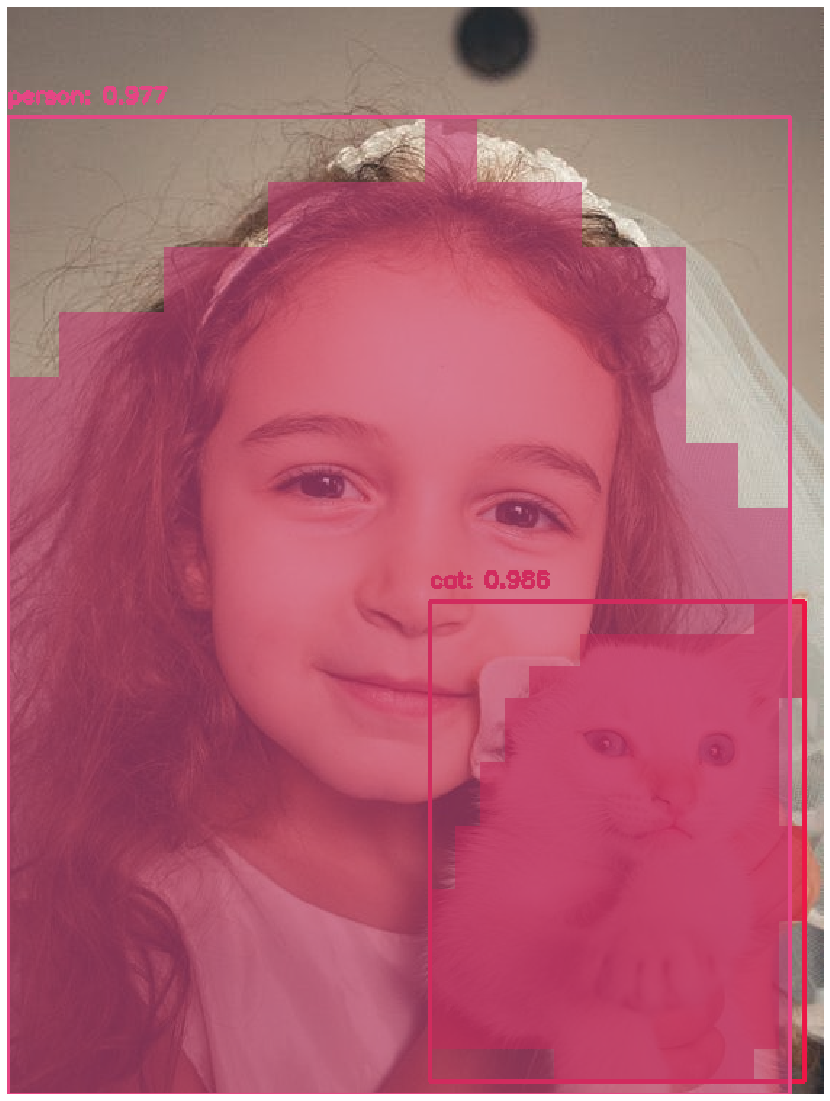

In [127]:
image = cv2.imread("Media/M4/girl_cat.jpeg")
segmentation(image)

#### Tunning the detection and mask threshold

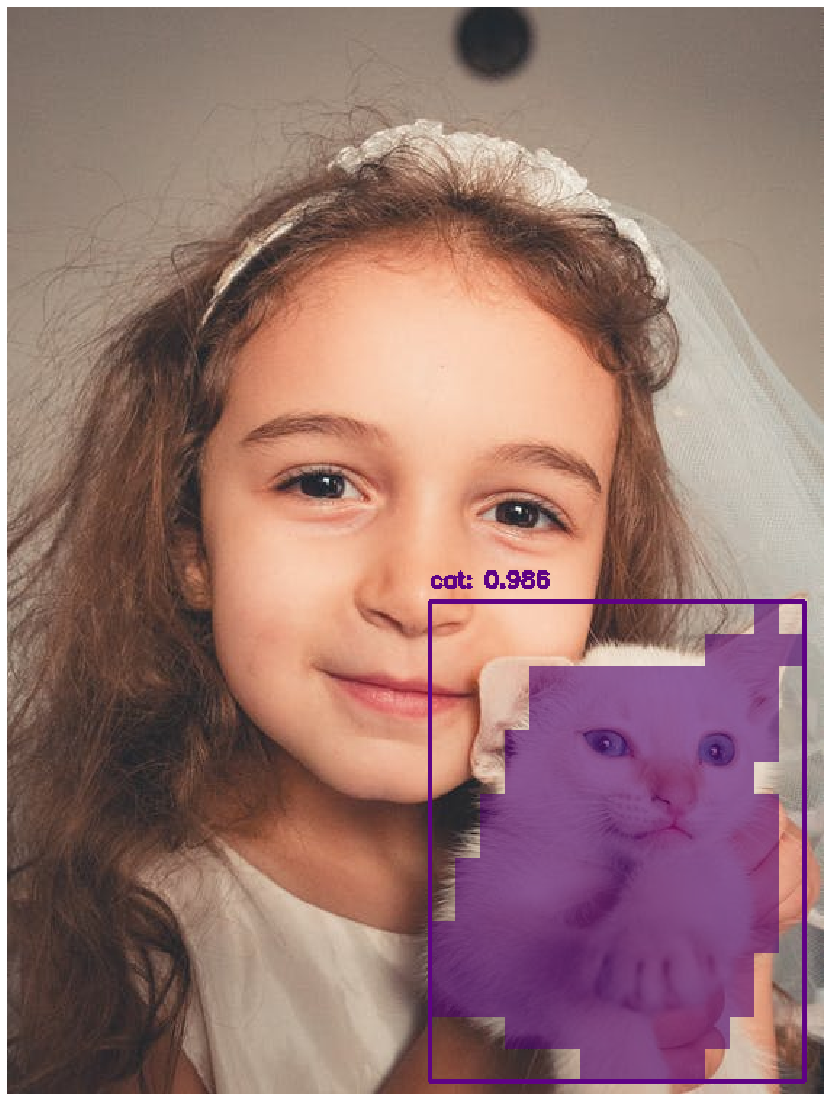

In [128]:
image = cv2.imread("Media/M4/girl_cat.jpeg")
segmentation(image,detect_thresh=0.98,mask_thresh=0.3)

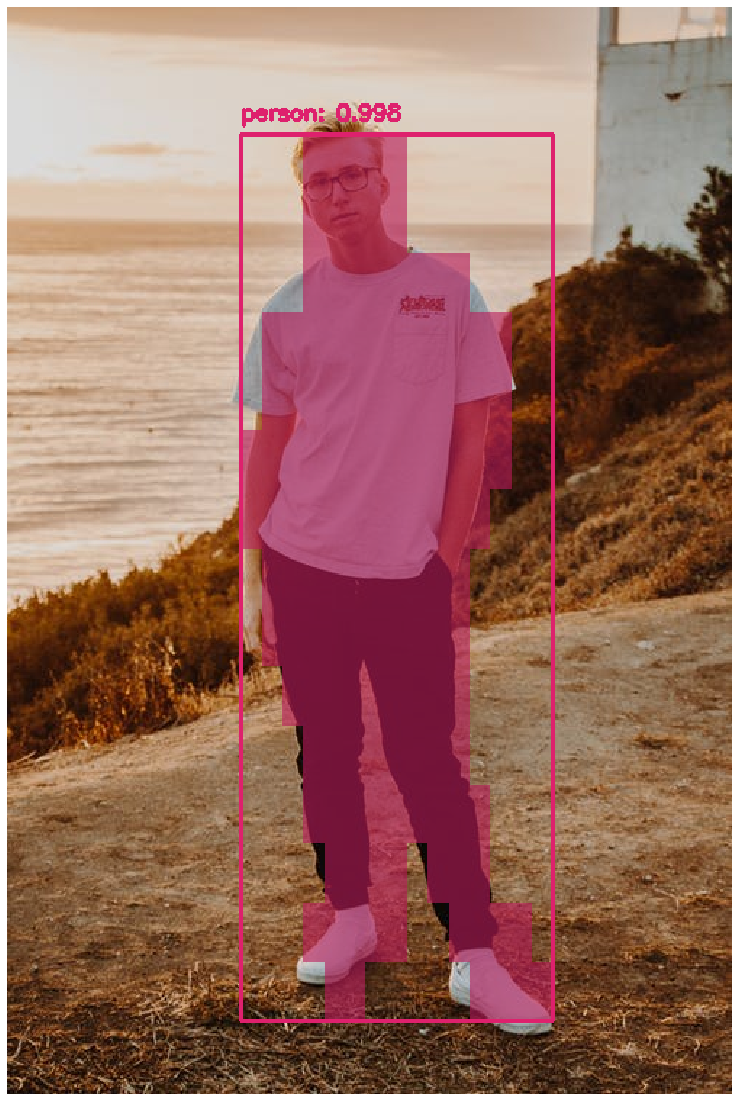

In [129]:
image = cv2.imread("Media/M4/pose3.jpeg")
segmentation(image)

***Image without Rectangular box***

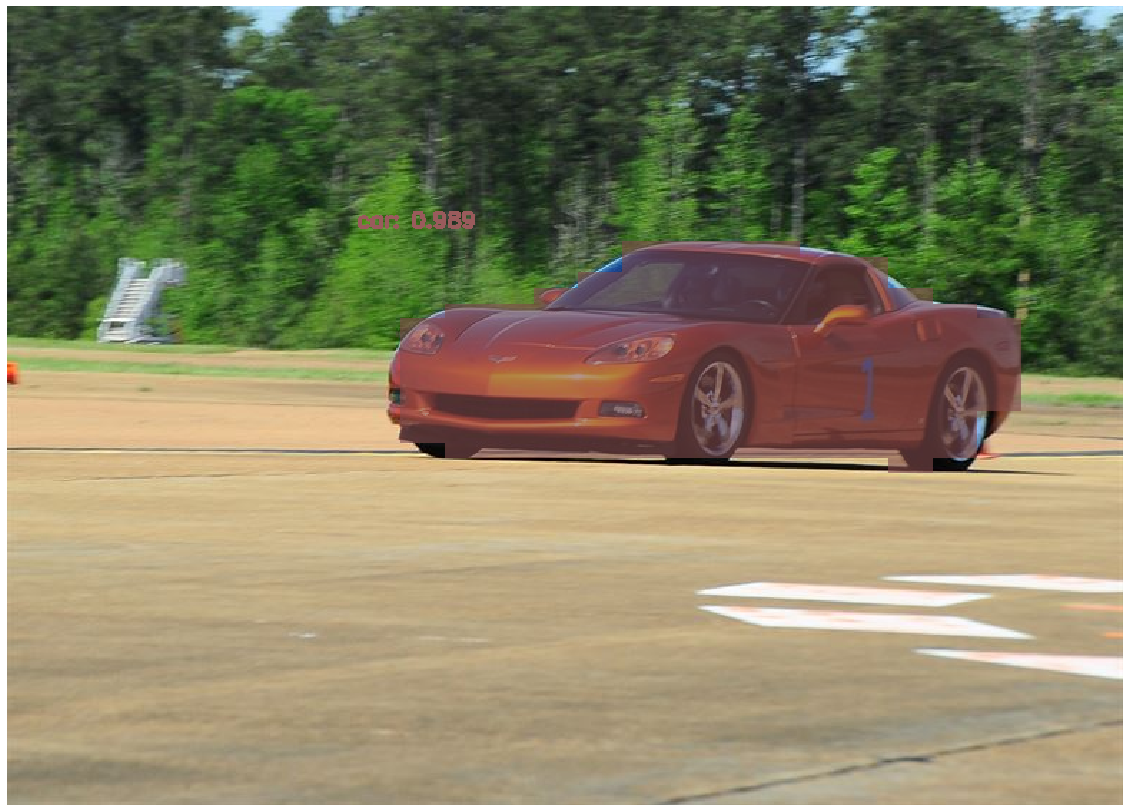

In [130]:
image = cv2.imread("Media/M4/spcar.jpg")
segmentation(image,draw_boxes=False, detect_thresh=0.6)

#### Taking the Image from the camera

In [ ]:
segmentation(usercam= True)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [131]:
init_segmentation()

In [133]:
%%time
image, _ = segmentation(image = image, returndata=True)

Wall time: 2.35 s


**Intel GPU**

In [ ]:
init_segmentation(usegpu = 'opencl')

In [ ]:
%%time
image,_= segmentation(image = image, returndata=True)

**NVIDIA GPU**

In [134]:
init_segmentation(usegpu = 'cuda')

In [137]:
%%time
image,_= segmentation(image = image, returndata=True)

Wall time: 1.57 s


## <font style="color:rgb(134,19,348)"> Image Segmentation On Video </font>

In [ ]:
# Initializing method
init_segmentation()

# Starting video reading mode
cap = cv2.VideoCapture('Media/M4/dpose.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Specifying Video writing path
out = cv2.VideoWriter(r'Media/M4/segmented.mp4',fourcc, 20.0, (1280,720))

while(True):
    
    ret, frame = cap.read()
    if not ret:
        break
        
    frame,_ = segmentation(frame,returndata=True)
    cv2.imshow('Segmented Video',frame)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    #print(final.shape)
cap.release()
out.release()
cv2.destroyAllWindows()